# XGBoost

* [Preliminary Run](#Preliminary-Run)
* [GridSearch](#GridSearch)
* [Final Model](#Final-Model)
* [Balance Testing](#Balance-Testing)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
teledf=pd.read_csv('data/teledf_final.csv', index_col=0)
teledf.head()

,Total day charge,Total intl calls,Area code_415,Area code_510,Total eve minutes,Total day minutes,Total day calls,Voice mail plan,Area code_408,Customer service calls,International plan,Churn,Number vmail messages,Total intl minutes,Total intl charge,Total eve charge
0,45.07,3.0,1.0,0.0,197.4,265.1,110.0,1.0,0.0,1.0,0.0,0.0,25.0,10.0,2.70,16.78
1,27.47,3.0,1.0,0.0,195.5,161.6,123.0,1.0,0.0,1.0,0.0,0.0,26.0,13.7,3.70,16.62
2,41.38,5.0,1.0,0.0,121.2,243.4,114.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2,3.29,10.30
3,50.90,7.0,0.0,0.0,61.9,299.4,71.0,0.0,1.0,2.0,1.0,0.0,0.0,6.6,1.78,5.26
4,28.34,3.0,1.0,0.0,148.3,166.7,113.0,0.0,0.0,3.0,1.0,0.0,0.0,10.1,2.73,12.61


In [4]:
from sklearn.model_selection import train_test_split

X=teledf.drop(columns='Churn')
y=teledf['Churn']

X_rest, X_test, y_rest, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_rest, y_rest, test_size=0.2, random_state=42)

# Preliminary Run

In [5]:
from xgboost import XGBClassifier

In [6]:
xgb_model=XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
xgb_model.score(X_train,y_train), xgb_model.score(X_val, y_val)

(0.9671669793621013, 0.9456928838951311)

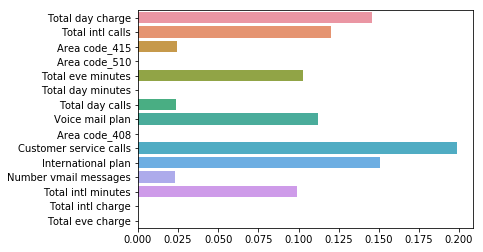

In [9]:
sns.barplot(y=X.columns,x=xgb_model.feature_importances_)

In [6]:
from sklearn.metrics import plot_confusion_matrix

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

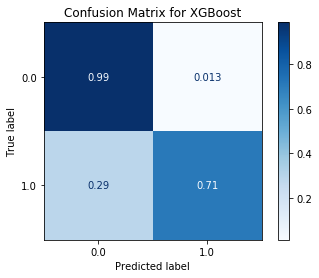

In [11]:
plot_confusion_matrix(xgb_model, 
                      X_val,
                      y_val,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for XGBoost')

Results of XGBoost are the best of the tested models (marginally better than normal gradient boosting).
Optimization will be conducted to finalize the XGBoost model, with the aim of decreasing false negative classifications (recall).

# GridSearch

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
grid_xgb=XGBClassifier(early_stopping_rounds=10, booster='gbtree', random_state=42)

params={
    'max_depth':[3,4,5,6,7],
    'learning_rate':[0.001,0.01,0.1,0.3],
    'min_child_weight':[1,3,5],
    'gamma':[0,0.1,0.3],
    'colsample_bytree':[0.3,0.5,0.8]
}



In [14]:
gridsearch_xgb = GridSearchCV(grid_xgb,
                             params,
                             scoring='recall',
                             cv=5,
                             n_jobs=-1)

In [15]:
gridsearch_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     early_stopping_rounds=10, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'gamma': [0, 0.1, 0.3],
    

In [16]:
gridsearch_xgb.best_score_

0.7516129032258064

In [17]:
gridsearch_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1}

# Final Model

In [7]:
xgb_final = XGBClassifier(colsample_bytree=0.8,
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=1,
                          early_stopping_rounds=10, booster='gbtree', random_state=42, )

In [8]:
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [9]:
xgb_final.score(X_train,y_train), xgb_final.score(X_val, y_val)

(0.9807692307692307, 0.951310861423221)

Text(0.5, 1.0, 'Confusion Matrix for Final XGBoost')

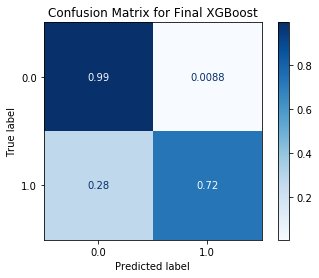

In [10]:
plot_confusion_matrix(xgb_final, 
                      X_val,
                      y_val,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Final XGBoost')

# Balance Testing

In [11]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

Using TensorFlow backend.


random_over_sampler.RandomOverSampler


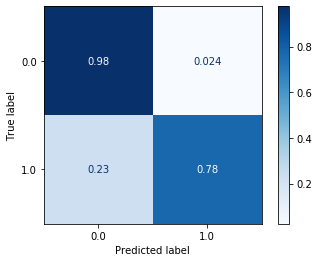

smote.SMOTE


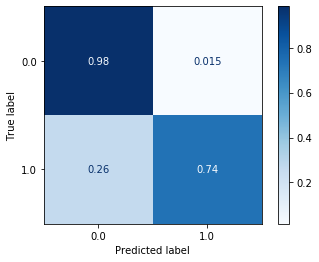

adasyn.ADASYN


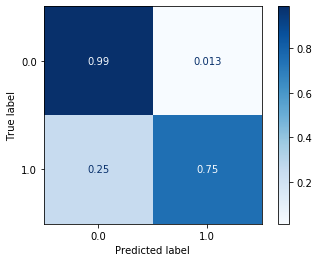

In [12]:
for i in [RandomOverSampler, SMOTE, ADASYN]:
    balancer = i(random_state = 42)
    X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)
    bal_xgb_model = xgb_final
    bal_xgb_model.fit(X_train_bal, y_train_bal)
    y_train_bal_pred = bal_xgb_model.predict(X_train_bal)
    y_test_bal_pred = bal_xgb_model.predict(X_test)
    print(f'{str(i)[32:-2]}')
    plot_confusion_matrix(bal_xgb_model, 
                      X_val,
                      y_val,
                      cmap='Blues', 
                      normalize='true')
    plt.show()

Best confusion matrix result from random oversampling XGBoost.
* recall score equal to Decision Tree result
* precision score is an improvement